<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Import Required libraries</b></font>
</p>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import os
import glob
import time
import numpy as np
from PIL import Image
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Digraph
from IPython.display import display
from IPython.display import Image as image_displayer


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>check for GPU</b></font>
</p>


In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Setting configuration</b></font>
</p>

In [4]:
np.random.seed(42)

# Basic configuration
BATCH_SIZE = 16
NUM_EPOCHS = 30
LEARNING_RATE = 1e-4


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Dataset and DataLoader Preparation</b></font>
</p>

In [5]:
class FVC2002Dataset(Dataset):
    """
    A class to load images from FVC2002.

    - load pairs of images: (image1, image2, label)
    - label = 1 if same user, 0 otherwise.
    """

    def __init__(self, root_dir, transform=None, num_negatives_per_positive=2):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        
        all_images = glob.glob(os.path.join(root_dir, "**", "*.tif"), recursive=True)
        
        # Dictionary user_id -> list of image paths
        user_dict = {}
        for img_path in all_images:
            filename = os.path.basename(img_path)
            # parse userID from filename or folder
            user_id = filename.split("_")[0]
            if user_id not in user_dict:
                user_dict[user_id] = []
            user_dict[user_id].append(img_path)
        
        # Now create pairs
        self.user_ids = list(user_dict.keys())
        for user_id in self.user_ids:
            # same-user pairs
            img_list = user_dict[user_id]
            for i in range(len(img_list)):
                for j in range(i+1, len(img_list)):
                    self.samples.append((img_list[i], img_list[j], 1))

             # ✅ For each positive pair, add N negative pairs
            for _ in range(num_negatives_per_positive):
                    # Pick random different user
                    negative_user_id = np.random.choice([u for u in self.user_ids if u != user_id])
                    negative_images = user_dict[negative_user_id]
                    if negative_images:
                        neg_img = np.random.choice(negative_images)
                        self.samples.append((img_list[i], neg_img, 0))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.samples[idx]
        
        img1 = Image.open(img1_path).convert("L")  # grayscale
        img2 = Image.open(img2_path).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.tensor(label, dtype=torch.float32)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create the dataset
dataset_root = "/kaggle/input/fvc2002-fingerprints/fingerprints"  # Adjust to your local path
dataset = FVC2002Dataset(root_dir=dataset_root, transform=transform, num_negatives_per_positive=7)

# Split dataset into train/test. 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

Number of training samples: 4024
Number of testing samples: 1006


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>visualize created pairs</b></font>
</p>

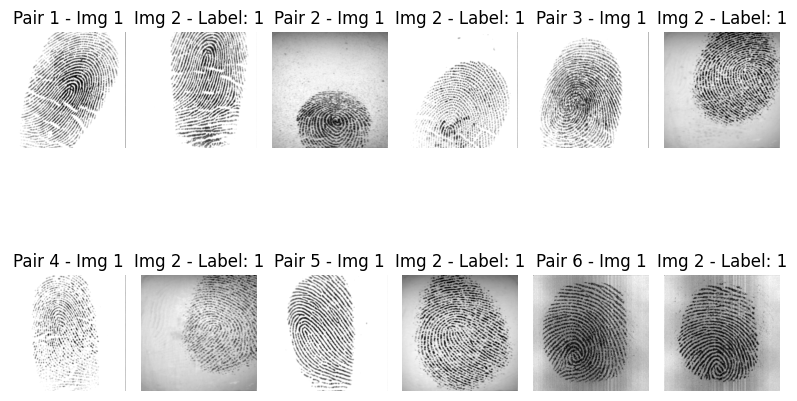

In [6]:
def visualize_pairs_two_per_row(dataset, num_pairs=6):
    """
    Visualizes image pairs from the dataset, displaying two pairs per row.

    Args:
        dataset (Dataset): The dataset to visualize.
        num_pairs (int): Total number of pairs to visualize.
    """
    pairs_per_row = 3
    num_rows = (num_pairs + 1) // pairs_per_row  # Round up

    fig, axes = plt.subplots(num_rows, pairs_per_row * 2, figsize=(8, num_rows * 3))
    if num_rows == 1:
        axes = [axes]  # Make it iterable for a single row

    for idx in range(num_pairs):
        image_1, image_2, label_to_display = dataset[idx]
        image_1 = TF.to_pil_image(image_1)
        image_2 = TF.to_pil_image(image_2)

        row = idx // pairs_per_row
        col_base = (idx % pairs_per_row) * 2

        ax1 = axes[row][col_base]
        ax2 = axes[row][col_base + 1]

        ax1.imshow(image_1, cmap='gray')
        ax1.set_title(f"Pair {idx+1} - Img 1")
        ax1.axis("off")

        ax2.imshow(image_2, cmap='gray')
        ax2.set_title(f"Img 2 - Label: {int(label_to_display.item())}")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

# Example: Visualize 6 pairs, 2 pairs per row
visualize_pairs_two_per_row(train_dataset, num_pairs=6)

<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Define a Siamese Network with Pretrained Backbone</b></font>
</p>

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self, backbone_name="resnet18", embedding_dim=128):
        super(SiameseNetwork, self).__init__()
        # Load a pretrained model as feature extractor
        if backbone_name == "resnet18":
            self.backbone = models.resnet18(pretrained=True)
            
            # Modify the first layer to accept 1-channel input instead of 3
            original_layer = self.backbone.conv1
            self.backbone.conv1 = nn.Conv2d(
                1, 64, 
                kernel_size=7, 
                stride=2, 
                padding=3, 
                bias=False
            )
            
            # Initialize the new layer with weights from the pretrained model
            # by averaging across the channel dimension
            with torch.no_grad():
                self.backbone.conv1.weight = nn.Parameter(
                    original_layer.weight.mean(dim=1, keepdim=True)
                )
                
            num_ftrs = self.backbone.fc.in_features
            # Remove the last FC layer
            self.backbone.fc = nn.Identity()
        else:
            raise NotImplementedError("Only 'resnet18' is implemented here for demonstration.")
        
        # Add a new FC layer to reduce to the embedding dimension
        self.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )

    def forward_once(self, x):
        # Extract features from backbone
        x = self.backbone(x)
        # Reduce to embedding
        x = self.fc(x)
        return x

    def forward(self, img1, img2):
        # Forward pass of two images
        emb1 = self.forward_once(img1)
        emb2 = self.forward_once(img2)
        return emb1, emb2

# Instantiate model
embedding_dim = 128  # dimension of the final embedding
model = SiameseNetwork(backbone_name="resnet18", embedding_dim=embedding_dim)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Visualize siamese network</b></font>
</p>

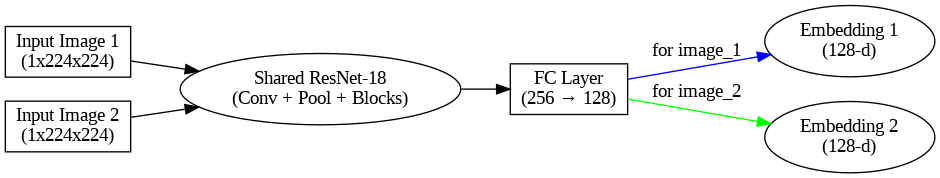

In [8]:
def visualize_siamese_network_inline():
    dot = Digraph(format='png')
    dot.attr(rankdir='LR', size='10')

    # Inputs
    dot.node('image_1', 'Input Image 1\n(1x224x224)', shape='box')
    dot.node('image_2', 'Input Image 2\n(1x224x224)', shape='box')

    # Shared backbone
    dot.node('backbone', 'Shared ResNet-18\n(Conv + Pool + Blocks)', shape='ellipse')

    # Embedding layer
    dot.node('fc', 'FC Layer\n(256 → 128)', shape='box')

    # Output embeddings
    dot.node('emb1', 'Embedding 1\n(128-d)', shape='oval')
    dot.node('emb2', 'Embedding 2\n(128-d)', shape='oval')

    # Edges
    dot.edge('image_1', 'backbone')
    dot.edge('image_2', 'backbone')
    dot.edge('backbone', 'fc')
    dot.edge('fc', 'emb1', label='for image_1', color='blue')
    dot.edge('fc', 'emb2', label='for image_2', color='green')

    # Render to a temporary file and display in notebook
    output_path = dot.render(filename='siamese_network', format='png', cleanup=True)
    display(image_displayer(filename=output_path))

# Call the function to show diagram inline
visualize_siamese_network_inline()

<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Define Loss Function and Optimizer</b></font>
</p>

In [9]:
class ContrastiveLoss(nn.Module):
    """ Contrastive loss """
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, emb1, emb2, label):
        # Calculate Euclidean distance
        dist = nn.functional.pairwise_distance(emb1, emb2)
        # Contrastive loss formula
        loss = 0.5 * (label * dist.pow(2) + (1 - label) * torch.pow(torch.clamp(self.margin - dist, min=0), 2))
        return loss.mean()

criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Training loop</b></font>
</p>

Epoch [1/30], Loss: 0.0935, time: 38.62076234817505
Epoch [2/30], Loss: 0.0069, time: 35.70968270301819
Epoch [3/30], Loss: 0.0052, time: 36.09735941886902
Epoch [4/30], Loss: 0.0038, time: 37.28085255622864
Epoch [5/30], Loss: 0.0030, time: 35.34988474845886
Epoch [6/30], Loss: 0.0021, time: 35.965301275253296
Epoch [7/30], Loss: 0.0024, time: 34.85124111175537
Epoch [8/30], Loss: 0.0016, time: 36.07081198692322
Epoch [9/30], Loss: 0.0026, time: 35.231411933898926
Epoch [10/30], Loss: 0.0013, time: 35.17027568817139
Epoch [11/30], Loss: 0.0028, time: 37.118430614471436
Epoch [12/30], Loss: 0.0032, time: 36.413222789764404
Epoch [13/30], Loss: 0.0020, time: 36.871615171432495
Epoch [14/30], Loss: 0.0015, time: 38.3546028137207
Epoch [15/30], Loss: 0.0026, time: 35.994991302490234
Epoch [16/30], Loss: 0.0018, time: 36.48166227340698
Epoch [17/30], Loss: 0.0024, time: 36.43164944648743
Epoch [18/30], Loss: 0.0031, time: 38.41205286979675
Epoch [19/30], Loss: 0.0014, time: 36.870761871337

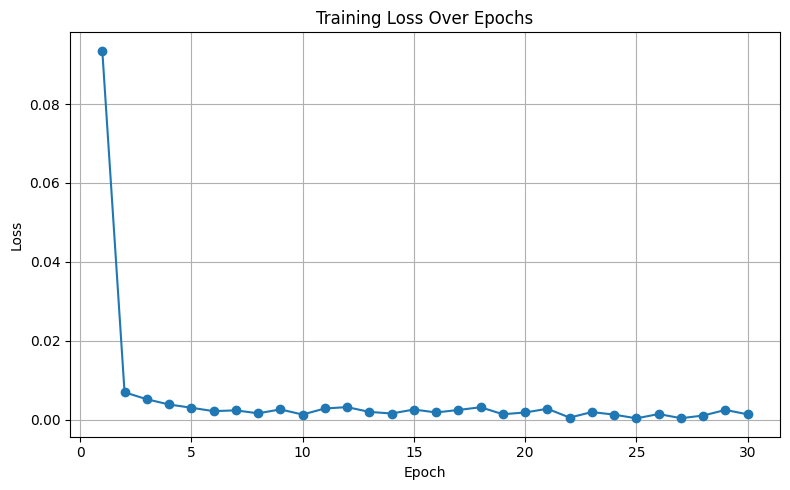

In [10]:
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        start_time = time.time()
        for img1, img2, labels in train_loader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            emb1, emb2 = model(img1, img2)
            loss = criterion(emb1, emb2, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, time: {epoch_time}")

    # 📈 Plot the loss curve after training
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-')
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return epoch_losses  # Optional: return losses for later use

# Call the training function
train_losses = train_model(model, criterion, optimizer, train_loader, num_epochs=NUM_EPOCHS)


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Save model</b></font>
</p>

In [11]:
torch.save(model, 'FingerPrint_30_epoch.pth')
print('model was saved successfully')

model was saved successfully


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Load model</b></font>
</p>

In [12]:
model = torch.load('FingerPrint_30_epoch.pth')
print('model was loaded successfully')

model was loaded successfully


<ipython-input-12-a58caaaa30d2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('FingerPrint_30_epoch.pth')


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Evaluation to Ensure > 90% Accuracy</b></font>
</p>

In [13]:
def evaluate_model(model, test_loader, threshold=0.5):
    model.eval()
    correct = 0
    total = 0
    processing_times = []
    
    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)

            # Start timing
            start_time = time.time()
            
            emb1, emb2 = model(img1, img2)
            dist = nn.functional.pairwise_distance(emb1, emb2)
            
            # Stop timing
            end_time = time.time()
            
            # Calculate and store time per image
            batch_size = labels.size(0)
            time_per_pair = (end_time - start_time) / batch_size
            
            for _ in range(batch_size):
                processing_times.append(time_per_pair)
            
            # Predict same user if dist < threshold
            preds = (dist < threshold).float()
            correct += (preds == labels).sum().item()
            total += batch_size

    accuracy = correct / total * 100
    avg_time = sum(processing_times) / len(processing_times)
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Average processing time per image pair: {avg_time*1000:.2f} ms")
    print(f"Total pairs evaluated: {len(processing_times)}")
    
    return accuracy, processing_times


# Run the evaluation
accuracy, processing_times = evaluate_model(model, test_loader, threshold=0.05)

# Calculate statistics
avg_time = sum(processing_times) / len(processing_times)
max_time = max(processing_times)
min_time = min(processing_times)
std_time = statistics.stdev(processing_times) if len(processing_times) > 1 else 0

print(f"Processing time statistics (in milliseconds):")
print(f"  Minimum: {min_time*1000:.2f} ms")
print(f"  Maximum: {max_time*1000:.2f} ms")
print(f"  Average: {avg_time*1000:.2f} ms")
print(f"  Std Dev: {std_time*1000:.2f} ms")

if accuracy >= 90:
    print("Requirement satisfied: Accuracy is above 90%.")
else:
    print("Accuracy below 90%, consider tuning hyperparameters or threshold.")

Test Accuracy: 91.35%
Average processing time per image pair: 0.36 ms
Total pairs evaluated: 1006
Processing time statistics (in milliseconds):
  Minimum: 0.32 ms
  Maximum: 1.05 ms
  Average: 0.36 ms
  Std Dev: 0.11 ms
Requirement satisfied: Accuracy is above 90%.


<p style="text-align:center;">
    <font face="Georgia" size=5 color="green"><b>Demonstration of Processing Times</b></font>
</p>

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


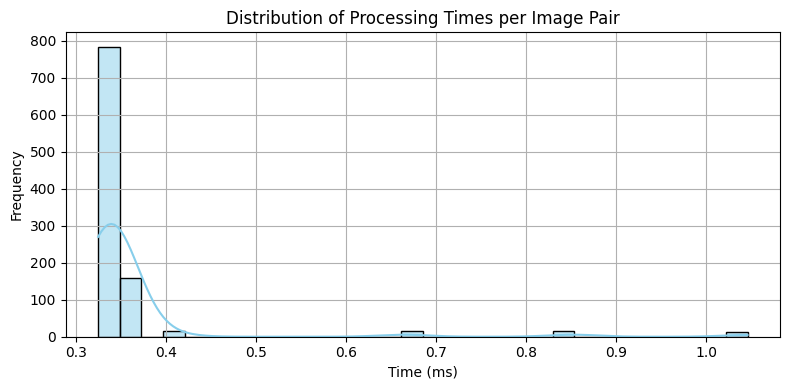

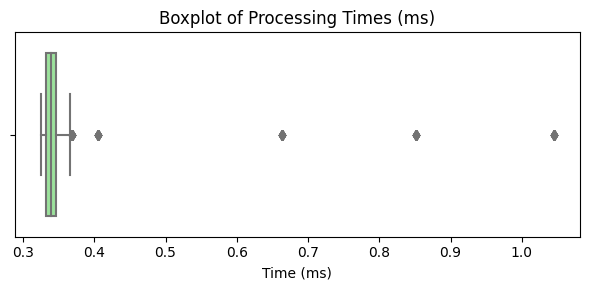

In [14]:
# --- Histogram of processing times ---
plt.figure(figsize=(8, 4))
sns.histplot([t * 1000 for t in processing_times], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Processing Times per Image Pair")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Boxplot for a cleaner summary (optional) ---
plt.figure(figsize=(6, 3))
sns.boxplot(x=[t * 1000 for t in processing_times], color="lightgreen")
plt.title("Boxplot of Processing Times (ms)")
plt.xlabel("Time (ms)")
plt.tight_layout()
plt.show()